Preparer le gpu

In [0]:
# preparer le gpu sur Google Colab
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

In [2]:
# importer librairies
import os
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

print(f"Your version of Pytorch is {torch.__version__}.")

Your version of Pytorch is 1.3.1.


In [3]:
# utiliser un gpu disponible
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

cuda


Lire et preparer les donnees

In [4]:
# utiliser les donnees sur mon drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# lire les donnees
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/PATCH.amat', sep="   ", header=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# diviser les donnees en ensembles d'entrainement et de test
import sklearn
from sklearn import model_selection
import numpy as np

x_train, x_test, y_train, y_test = model_selection.train_test_split(data.loc[:,:783], data.loc[:,784], test_size=0.2, random_state=0)

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [0]:
# reshape les donnees
x_train_2 = np.zeros((x_train.shape[0], 28, 28))
for i, vect in enumerate(x_train):
  x_train_2[i] = np.reshape(vect, (28,28))

x_test_2 = np.zeros((x_test.shape[0], 28, 28))
for i, vect in enumerate(x_test):
  x_test_2[i] = np.reshape(vect, (28,28))

x_train = x_train_2.copy()
x_test = x_test_2.copy()

In [0]:
# ajuster les dimensions pour pytorch
x_train = np.expand_dims(x_train,axis=1)
x_test = np.expand_dims(x_test,axis=1)

In [0]:
# transformer les donnees en pytorch et les formater de facon appropriee
x_train = ((torch.from_numpy(x_train) - 0.5)/0.5).float()
x_test = ((torch.from_numpy(x_test) - 0.5)/0.5).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

In [0]:
# transformer les donnees en dataset
from torch.utils import data

train_data = data.TensorDataset(x_train,y_train)
test_data = data.TensorDataset(x_test,y_test)

In [0]:
# charger les ensembles d'entrainement, validation et test pour nos modeles

from torch.utils.data import DataLoader
from torch.utils.data.sampler import (SubsetRandomSampler, RandomSampler)

# echantillonage aleatoire de l'ensemble de validation
indices = list(range(len(train_data)))
random.shuffle(indices)

# nombre d'exemples de validation
n_valid = 10000

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=SubsetRandomSampler(indices[n_valid:]), num_workers=1, pin_memory=use_cuda)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=SubsetRandomSampler(indices[:n_valid]), num_workers=1, pin_memory=use_cuda)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=1, pin_memory=use_cuda)

Modelisation

In [0]:
# fonction de cout
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

# sauvegarder les courbes d'apprentissage de plusieurs modeles
savedir = '/content/drive/My Drive/Colab Notebooks/Saves'
if not os.path.exists(savedir):
    os.makedirs(savedir)

In [0]:
# fonction d'entrainement de modele
def train(model,train_loader, optimizer, epoch ):
    model.train()
    
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device)

        loss = torch.zeros(1)
        optimizer.zero_grad()

        preds = model(inputs)
        loss = loss_fn(preds, target)

        loss.backward()
        optimizer.step()   
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader) *len(inputs) ,
                100. * batch_idx / len(train_loader), loss.item()))
            

In [0]:
# fonction de test de modele
def test(model, test_loader):

    model.eval()
    
    test_loss = 0 
    correct = 0 
    test_size = 0 

    
    with torch.no_grad():
      
        for inputs, target in test_loader:
            inputs, target = inputs.to(device), target.to(device)

            test_size += len(inputs)

            preds = model(inputs)
            test_loss += loss_fn(preds, target).item()

            pred = preds.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= test_size
    accuracy = correct / test_size
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, test_size, 100. * accuracy))
    
    return test_loss, accuracy

In [0]:
# modele de reseau de convolutions
class ConvNet2(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 512, 3, padding=1, stride=1)
        #self.drop1 = nn.Dropout(p=0.05)
        self.conv2 = nn.Conv2d(512, 512, 3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(512, 256, 3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(256, 64, 3, padding=1, stride=1)
        self.fc = nn.Linear(64*3*3, 2)

    def forward(self, xin):

        x = F.relu(self.conv1(xin))
        x = F.max_pool2d(x, 2) 

        #x = self.drop1(x)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2) 

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2) 

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 1) 
        
        flatten_size = 64*3*3
        #print(x.shape)
        x = x.view(-1, flatten_size)
        x = F.relu(self.fc(x))
        return x
    

In [179]:
# entrainement du modele

model = ConvNet2().to(device)

lr = 0.0005
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

results = {'name':'ConvNet2_', 'lr': lr, 'loss': [], 'accuracy':[]}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(1, 200):
    train(model, train_loader, optimizer, epoch)
    loss, acc = test(model, valid_loader)
    
    # sauvegarder les resultats
    results['loss'].append(loss)
    results['accuracy'].append(acc)
    with open(savefile, 'wb') as fout:
        pickle.dump(results, fout)

Train Epoch: 1 [0/30016 (0%)]	Loss: 0.691774
Train Epoch: 1 [320/30016 (1%)]	Loss: 0.692253
Train Epoch: 1 [640/30016 (2%)]	Loss: 0.693199
Train Epoch: 1 [960/30016 (3%)]	Loss: 0.694416
Train Epoch: 1 [1280/30016 (4%)]	Loss: 0.688762
Train Epoch: 1 [1600/30016 (5%)]	Loss: 0.691479
Train Epoch: 1 [1920/30016 (6%)]	Loss: 0.690541
Train Epoch: 1 [2240/30016 (7%)]	Loss: 0.686490
Train Epoch: 1 [2560/30016 (9%)]	Loss: 0.687140
Train Epoch: 1 [2880/30016 (10%)]	Loss: 0.693377
Train Epoch: 1 [3200/30016 (11%)]	Loss: 0.689225
Train Epoch: 1 [3520/30016 (12%)]	Loss: 0.686980
Train Epoch: 1 [3840/30016 (13%)]	Loss: 0.693237
Train Epoch: 1 [4160/30016 (14%)]	Loss: 0.684602
Train Epoch: 1 [4480/30016 (15%)]	Loss: 0.686289
Train Epoch: 1 [4800/30016 (16%)]	Loss: 0.687140
Train Epoch: 1 [5120/30016 (17%)]	Loss: 0.689892
Train Epoch: 1 [5440/30016 (18%)]	Loss: 0.683354
Train Epoch: 1 [5760/30016 (19%)]	Loss: 0.679265
Train Epoch: 1 [6080/30016 (20%)]	Loss: 0.683339
Train Epoch: 1 [6400/30016 (21%)]	L

In [180]:
# evaluer la performance de notre model
test(model, test_loader)

Test set: Average loss: 0.0030, Accuracy: 9864/10000 (98.6400%)



(0.0029532936453819277, 0.9864)

Predictions

In [0]:
# lire les donnees a predire
pred = pd.read_csv('/content/drive/My Drive/Colab Notebooks/PATCH_test.amat', sep=" ", header=None)

In [0]:
# reshape les donnees
x_pred = pred.to_numpy()

x_pred_2 = np.zeros((x_pred.shape[0], 28, 28))
for i, vect in enumerate(x_pred):
  x_pred_2[i] = np.reshape(vect, (28,28))


x_pred = x_pred_2.copy()

In [0]:
# ajuster les dimensions pour pytorch
x_pred = np.expand_dims(x_pred,axis=1)

In [0]:
# transformer les donnees en pytorch et les formater de facon appropriee
x_pred = ((torch.from_numpy(x_pred) - 0.5)/0.5).float()

In [0]:
# transformer les donnees en dataset
pred_data = data.TensorDataset(x_pred)

In [0]:
# charger les ensembles d'entrainement, validation et test pour nos modeles
pred_loader = DataLoader(pred_data, batch_size=batch_size, num_workers=1, pin_memory=use_cuda)

In [0]:
# fonction de prediction
def predict(model, pred_loader):

    model.eval()
    predictions = np.array([])

    with torch.no_grad():
      
        for inputs in pred_loader:
            inputs = inputs[0]
            inputs = inputs.to(device)

            preds = model(inputs)

            pred = preds.max(1, keepdim=True)[1]
            pred = pred.cpu().numpy().flatten()

            predictions = np.concatenate((predictions, pred), axis=0)

    return predictions.astype(int)

In [0]:
# predire les classes de chaque input de l'ensemble de prediction
predictions = predict(model, pred_loader)

In [183]:
predictions

array([0, 1, 0, ..., 1, 1, 1])

In [0]:
# sauvegarder les predictions en tant que csv
import csv

with open('/content/drive/My Drive/Colab Notebooks/Saves/preds_IFT3700.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(['Id', 'Category'])
    i=0
    for word in predictions:
        wr.writerow([i, word])
        i+=1

Visualisation des courbes d'apprentissage

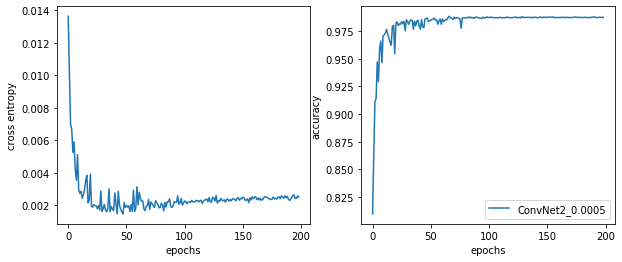

In [186]:
# visualiser les courbes d'apprentissage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for filename in os.listdir(savedir):
    if filename.endswith('.pkl'):
        with open(os.path.join(savedir, filename),'rb') as fin:
            results = pickle.load(fin)
            ax1.plot(results['loss'])
            ax1.set_ylabel('cross entropy')
            ax1.set_xlabel('epochs')
            
            ax2.plot(results['accuracy'], label = filename[:-4])
            ax2.set_ylabel('accuracy')
            ax2.set_xlabel('epochs')
            
plt.legend()